# Import Report Analysis

> Adjust `report_path` in the next cell if needed. This notebook summarizes timings, output sizes, and per-job stats, and produces charts.

In [128]:
from __future__ import annotations

import json
import math
from collections import defaultdict
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt

# Configure manifest path (update as needed).
manifest_candidates = [
    Path("Testing/manifest-mixed.json"),
    Path("src/Oxygen/Content/Tools/ImportTool/Testing/manifest-mixed.json"),
]
manifest_path = next((p for p in manifest_candidates if p.exists()), manifest_candidates[0])

if not manifest_path.exists():
    raise FileNotFoundError(f"Manifest not found: {manifest_path}")

if "manifest-" not in manifest_path.name:
    raise ValueError("Manifest filename must include 'manifest-' to derive report name")

report_file = manifest_path.name.replace("manifest-", "report-", 1)
report_path = manifest_path.parent / "Cooked/.cooked" / report_file

if not report_path.exists():
    raise FileNotFoundError(f"Report not found: {report_path}")

report: dict[str, Any] = json.loads(report_path.read_text(encoding="utf-8"))
jobs = report.get("jobs", [])
session = report.get("session", {})
summary = report.get("summary", {})

def ms(value: Any) -> float:
    return 0.0 if value is None else float(value)

In [129]:
def work_items_count(job: dict[str, Any]) -> int:
    return len(job.get("work_items", []))

def first_item_label(job: dict[str, Any]) -> str:
    items = job.get("work_items", [])
    if not items:
        return ""
    item = items[0]
    name = item.get("name", "")
    kind = item.get("type", "")
    if name and kind:
        return f"{kind}:{name}"
    return name or kind or ""

def job_stats(job: dict[str, Any]) -> dict[str, float]:
    stats = job.get("stats", {})
    return {
        "total_ms": ms(stats.get("time_ms_total")),
        "io_ms": ms(stats.get("time_ms_io")),
        "decode_ms": ms(stats.get("time_ms_decode")),
        "load_ms": ms(stats.get("time_ms_load")),
        "cook_ms": ms(stats.get("time_ms_cook")),
        "emit_ms": ms(stats.get("time_ms_emit")),
        "finalize_ms": ms(stats.get("time_ms_finalize")),
    }

job_rows = []
for job in jobs:
    stats = job_stats(job)
    job_rows.append({
        "index": job.get("index", ""),
        "type": job.get("type", ""),
        "status": job.get("status", ""),
        "work_items": work_items_count(job),
        "first_item": first_item_label(job),
        **stats,
    })

job_rows

[{'index': 1,
  'type': 'texture',
  'status': 'succeeded',
  'work_items': 1,
  'first_item': 'Texture:Wood.png',
  'total_ms': 18.344,
  'io_ms': 4.687,
  'decode_ms': 5.767,
  'load_ms': 4.716,
  'cook_ms': 2.429,
  'emit_ms': 0.177,
  'finalize_ms': 2.265},
 {'index': 2,
  'type': 'texture',
  'status': 'succeeded',
  'work_items': 1,
  'first_item': 'Texture:hdr_skybox_f32.hdr',
  'total_ms': 250.168,
  'io_ms': 42.403,
  'decode_ms': 50.262,
  'load_ms': 42.423,
  'cook_ms': 144.213,
  'emit_ms': 2.282,
  'finalize_ms': 8.052},
 {'index': 3,
  'type': 'gltf',
  'status': 'succeeded',
  'work_items': 561,
  'first_item': 'MeshBuild:NewSponza_Main_glTF_003/roof_floor_03_05',
  'total_ms': 4166.765,
  'io_ms': 18518.763,
  'decode_ms': 17427.989,
  'load_ms': 30.992,
  'cook_ms': 11522.485,
  'emit_ms': 645.147,
  'finalize_ms': 80.76},
 {'index': 4,
  'type': 'fbx',
  'status': 'succeeded',
  'work_items': 13,
  'first_item': 'MeshBuild:geom-buffer:F:/projects/DroidNet/projects/Oxy

In [130]:
def work_item_duration_ms(item: dict[str, Any]) -> float | None:
    started = item.get("started_ms")
    finished = item.get("finished_ms")
    if started is None or finished is None:
        return None
    return float(finished) - float(started)

work_item_rows = []
for job in jobs:
    for item in job.get("work_items", []):
        work_item_rows.append({
            "type": item.get("type", ""),
            "name": item.get("name", ""),
            "started_ms": item.get("started_ms"),
            "finished_ms": item.get("finished_ms"),
            "duration_ms": work_item_duration_ms(item),
        })

work_item_rows[:5]

[{'type': 'Texture',
  'name': 'Wood.png',
  'started_ms': 7.4836,
  'finished_ms': 16.069,
  'duration_ms': 8.5854},
 {'type': 'Texture',
  'name': 'hdr_skybox_f32.hdr',
  'started_ms': 45.1041,
  'finished_ms': 242.0893,
  'duration_ms': 196.98520000000002},
 {'type': 'MeshBuild',
  'name': 'NewSponza_Main_glTF_003/roof_floor_03_05',
  'started_ms': 292.6052,
  'finished_ms': 331.8161,
  'duration_ms': 39.21089999999998},
 {'type': 'MeshBuild',
  'name': 'NewSponza_Main_glTF_003/lamps_1stfloor_02',
  'started_ms': 166.3446,
  'finished_ms': 173.8885,
  'duration_ms': 7.543899999999979},
 {'type': 'Texture',
  'name': 'F:/projects/main_sponza/NewSponza_Main_glTF_003.gltf::tex::arch_stone_wall_01_BaseColor.png::base_color',
  'started_ms': 113.6676,
  'finished_ms': 900.2956,
  'duration_ms': 786.628}]

In [131]:
# Display a compact table (uses pandas if available).
try:
    import pandas as pd
    df = pd.DataFrame(job_rows)
    df
except Exception:
    for row in job_rows:
        print(row)

{'index': 1, 'type': 'texture', 'status': 'succeeded', 'work_items': 1, 'first_item': 'Texture:Wood.png', 'total_ms': 18.344, 'io_ms': 4.687, 'decode_ms': 5.767, 'load_ms': 4.716, 'cook_ms': 2.429, 'emit_ms': 0.177, 'finalize_ms': 2.265}
{'index': 2, 'type': 'texture', 'status': 'succeeded', 'work_items': 1, 'first_item': 'Texture:hdr_skybox_f32.hdr', 'total_ms': 250.168, 'io_ms': 42.403, 'decode_ms': 50.262, 'load_ms': 42.423, 'cook_ms': 144.213, 'emit_ms': 2.282, 'finalize_ms': 8.052}
{'index': 3, 'type': 'gltf', 'status': 'succeeded', 'work_items': 561, 'first_item': 'MeshBuild:NewSponza_Main_glTF_003/roof_floor_03_05', 'total_ms': 4166.765, 'io_ms': 18518.763, 'decode_ms': 17427.989, 'load_ms': 30.992, 'cook_ms': 11522.485, 'emit_ms': 645.147, 'finalize_ms': 80.76}
{'index': 4, 'type': 'fbx', 'status': 'succeeded', 'work_items': 13, 'first_item': 'MeshBuild:geom-buffer:F:/projects/DroidNet/projects/Oxygen.Engine/src/Oxygen/Content/Tools/ImportTool/Testing/Models/dino-a.fbx::dino-a/

In [132]:
# Aggregate time across jobs
totals = {
    "io_ms": 0.0,
    "decode_ms": 0.0,
    "load_ms": 0.0,
    "cook_ms": 0.0,
    "emit_ms": 0.0,
    "finalize_ms": 0.0,
    "total_ms": 0.0,
}
for row in job_rows:
    for key in totals:
        totals[key] += row.get(key, 0.0)

totals


{'io_ms': 33262.724,
 'decode_ms': 33887.815,
 'load_ms': 6088.558,
 'cook_ms': 18691.482,
 'emit_ms': 1031.663,
 'finalize_ms': 165.14,
 'total_ms': 13897.988000000001}

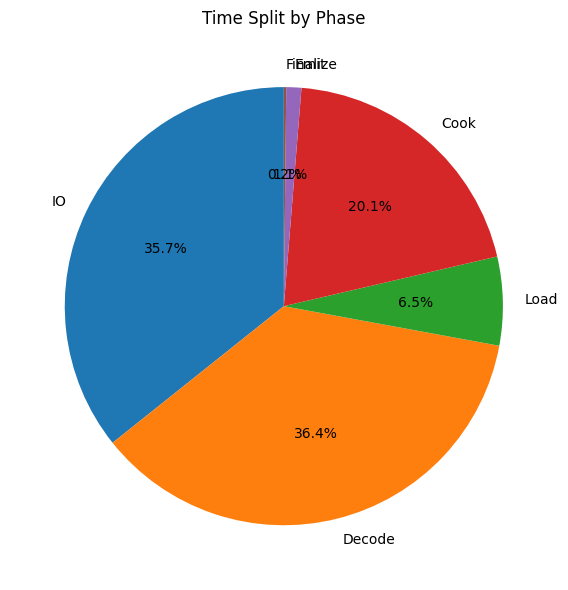

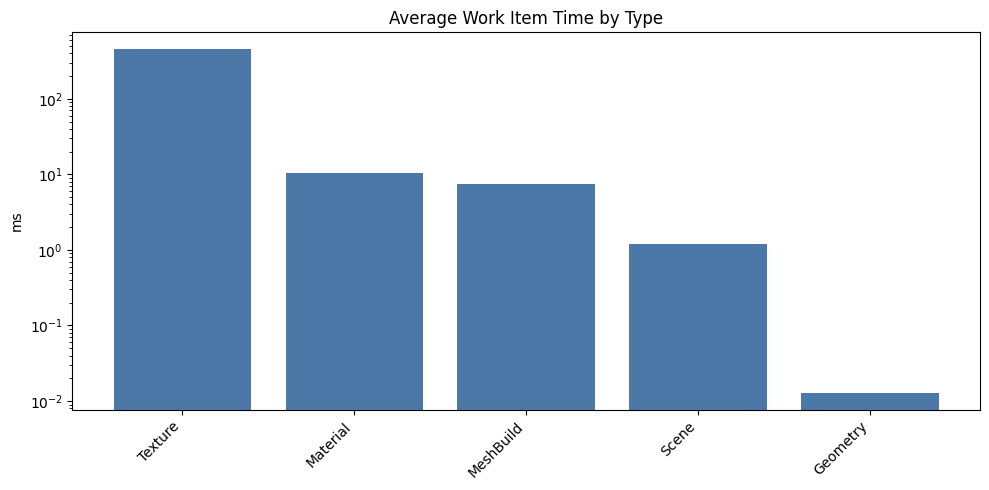

C:\Users\abdes\AppData\Local\Temp\ipykernel_49012\3397596076.py:61: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


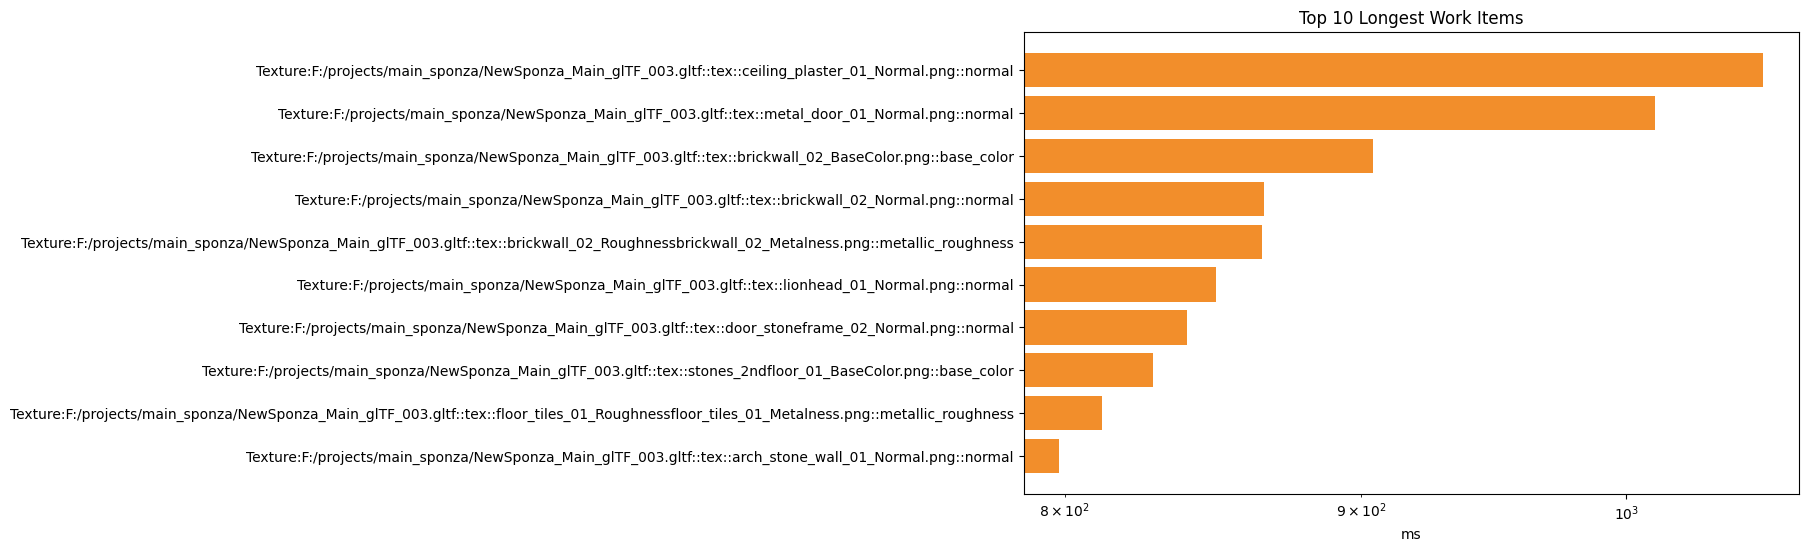

In [133]:
# Charts: time split + average time by type + top 10 longest work items
phase_keys = ["io_ms", "decode_ms", "load_ms", "cook_ms", "emit_ms", "finalize_ms"]
phase_labels = ["IO", "Decode", "Load", "Cook", "Emit", "Finalize"]
phase_values = [totals[k] for k in phase_keys]
phase_pairs = [(label, value) for label, value in zip(phase_labels, phase_values) if value > 0]

if phase_pairs:
    labels, values = zip(*phase_pairs)
    plt.figure(figsize=(6, 6))
    plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=90)
    plt.title("Time Split by Phase")
    plt.tight_layout()
    plt.show()
else:
    print("No phase timing data available.")

use_log_scale = True

type_sums = defaultdict(float)
type_counts = defaultdict(int)
for item in work_item_rows:
    duration_ms = item.get("duration_ms")
    if duration_ms is not None:
        key = item.get("type", "unknown")
        type_sums[key] += duration_ms
        type_counts[key] += 1

type_avgs = {
    key: (type_sums[key] / type_counts[key])
    for key in type_sums
    if type_counts[key] > 0
}

if type_avgs:
    sorted_types = sorted(type_avgs.items(), key=lambda kv: kv[1], reverse=True)
    labels = [t for t, _ in sorted_types]
    values = [v for _, v in sorted_types]
    plt.figure(figsize=(10, 5))
    plt.bar(labels, values, color="#4C78A8")
    plt.title("Average Work Item Time by Type")
    plt.ylabel("ms")
    if use_log_scale:
        plt.yscale("log")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("No work item timing data available for type distribution.")

longest = [item for item in work_item_rows if item.get("duration_ms") is not None]
longest = sorted(longest, key=lambda i: i["duration_ms"], reverse=True)[:10]
if longest:
    labels = [f"{i['type']}:{i['name']}" for i in longest][::-1]
    values = [i["duration_ms"] for i in longest][::-1]
    plt.figure(figsize=(10, 6))
    plt.barh(labels, values, color="#F28E2B")
    plt.title("Top 10 Longest Work Items")
    plt.xlabel("ms")
    if use_log_scale:
        plt.xscale("log")
    plt.tight_layout()
    plt.show()
else:
    print("No work item duration data available for longest items.")

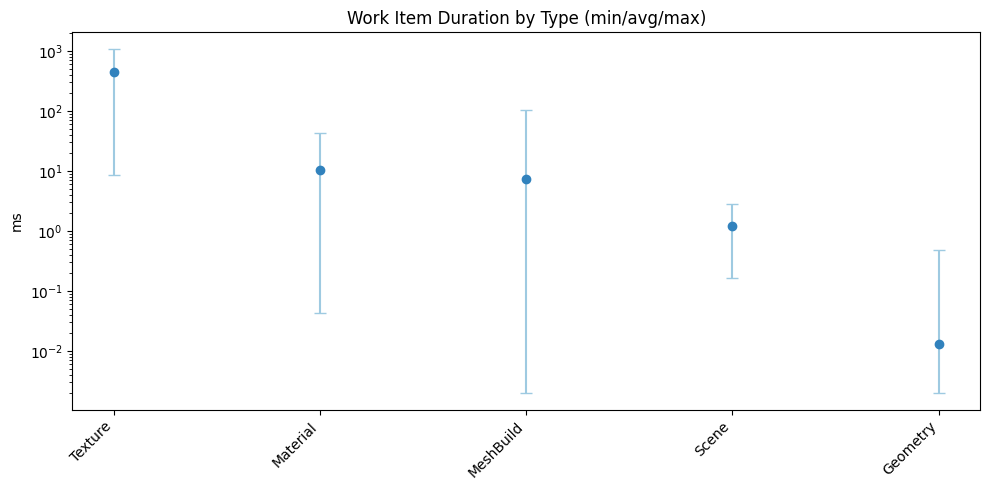

In [134]:
# Interval chart: min/avg/max duration per type
type_values: dict[str, list[float]] = defaultdict(list)
for item in work_item_rows:
    duration_ms = item.get("duration_ms")
    if duration_ms is not None and duration_ms >= 0:
        type_values[item.get("type", "unknown")].append(duration_ms)

interval_rows = []
for key, values in type_values.items():
    if not values:
        continue
    interval_rows.append({
        "type": key,
        "min": min(values),
        "avg": sum(values) / len(values),
        "max": max(values),
        "count": len(values),
    })

if interval_rows:
    interval_rows.sort(key=lambda row: row["avg"], reverse=True)
    labels = [row["type"] for row in interval_rows]
    mins = [row["min"] for row in interval_rows]
    avgs = [row["avg"] for row in interval_rows]
    maxs = [row["max"] for row in interval_rows]
    lower = [max(0.0, avg - mn) for avg, mn in zip(avgs, mins)]
    upper = [max(0.0, mx - avg) for mx, avg in zip(maxs, avgs)]
    x = list(range(len(labels)))
    plt.figure(figsize=(10, 5))
    plt.errorbar(
        x,
        avgs,
        yerr=[lower, upper],
        fmt="o",
        ecolor="#9ecae1",
        color="#3182bd",
        capsize=4,
    )
    plt.xticks(x, labels, rotation=45, ha="right")
    plt.title("Work Item Duration by Type (min/avg/max)")
    plt.ylabel("ms")
    if globals().get("use_log_scale", True):
        plt.yscale("log")
    plt.tight_layout()
    plt.show()
else:
    print("No work item duration data available for interval chart.")